## Investigate a Dataset - European Soccer Database

## Data Set
European Soccer Database

## Overview and Notes
This soccer database comes from Kaggle and is well suited for data analysis and machine learning.  
It contains data for soccer matches, players, and teams from several European countries from 2008 to 2016.  
This dataset is quite extensive, and we encourage you to read more about it here.  
The database is stored in a SQLite database. You can access database files using software like DB Browser.  
This dataset will help you get good practice with your SQL joins.  
Make sure to look at how the different tables relate to each other.  
Some column titles should be self-explanatory, and others you’ll have to look up on Kaggle.  

## Sources
https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True  
https://www.kaggle.com/hugomathien/soccer

## Example Questions
How many goals has each team scored home, away and total on each season?  
How many goals has each team allowed home, away and total on each season?  
What teams improved the most over the time period?  
Which players had the most penalties?  
What team attributes lead to the most victories?  



## Import data analysis modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

## Connect to the local sqlite database with the following tables:  
## Country, League, Match, Player, Player_Attributes, Team, Team_Attributes

In [2]:
connection = sqlite3.connect('database.sqlite')

## Run any query, store and display results in a DataFrame
## Select Country, League, Date, Team Home, Team Away and the final score for every match in the dataset that belongs to the Spanish LIGA BBVA league.

In [3]:
query = '''
select 
    Country.name as Country, 
    League.name as League, 
    Match.season as Season,
    date(Match.date) as Date,
    Team_home.team_long_name as Team_Home, 
    Team_away.team_long_name as Team_Away, 
    Match.home_team_goal as Team_Home_Goal, 
    Match.away_team_goal as Team_Away_Goal
from
    Country, League, Team as Team_home, Team as Team_away, Match
where
    Country.id = League.country_id AND
    Country.id = Match.country_id AND
    League.id = Match.league_id AND
    Team_home.team_api_id = Match.home_team_api_id AND
    Team_away.team_api_id = Match.away_team_api_id AND
    Country = 'Spain' AND
    League.name = 'Spain LIGA BBVA'
order by
    Match.date
-- limit 1000;
'''

#Run query and store results in a dataframe
spain_liga_bbva_df = pd.read_sql(query,connection)

## Print columns in the dataframe

In [4]:
print(spain_liga_bbva_df.columns)

Index([u'Country', u'League', u'Season', u'Date', u'Team_Home', u'Team_Away',
       u'Team_Home_Goal', u'Team_Away_Goal'],
      dtype='object')


## Look at any game Team Barcelona has played in this dataset

In [5]:
#print df[df['Team_Home'].str.contains('Barcelona', case = False)]
fc_barcelona_df = spain_liga_bbva_df[(spain_liga_bbva_df['Team_Home'] == 'FC Barcelona') | (spain_liga_bbva_df['Team_Away'] == 'FC Barcelona')]
fc_barcelona_df.tail(10)

,Country,League,Season,Date,Team_Home,Team_Away,Team_Home_Goal,Team_Away_Goal
2942,Spain,Spain LIGA BBVA,2015/2016,2016-03-12,FC Barcelona,Getafe CF,6,0
2956,Spain,Spain LIGA BBVA,2015/2016,2016-03-20,Villarreal CF,FC Barcelona,2,2
2961,Spain,Spain LIGA BBVA,2015/2016,2016-04-02,FC Barcelona,Real Madrid CF,1,2
2972,Spain,Spain LIGA BBVA,2015/2016,2016-04-09,Real Sociedad,FC Barcelona,1,0
2986,Spain,Spain LIGA BBVA,2015/2016,2016-04-17,FC Barcelona,Valencia CF,1,2
2994,Spain,Spain LIGA BBVA,2015/2016,2016-04-20,RC Deportivo de La Coruña,FC Barcelona,0,8
3003,Spain,Spain LIGA BBVA,2015/2016,2016-04-23,FC Barcelona,Real Sporting de Gijón,6,0
3012,Spain,Spain LIGA BBVA,2015/2016,2016-04-30,Real Betis Balompié,FC Barcelona,0,2
3025,Spain,Spain LIGA BBVA,2015/2016,2016-05-08,FC Barcelona,RCD Espanyol,5,0
3032,Spain,Spain LIGA BBVA,2015/2016,2016-05-14,Granada CF,FC Barcelona,0,3


## Compute number of unique seasons

In [6]:
unique_seasons = pd.Series(spain_liga_bbva_df['Season'].unique())

## Create helpful funtions that will be used repeatedly for resetting an index of an input series, store result in a dataframe, pivot it  so that each Season is a seperate column and finally plot its input columns over its input index

In [7]:
"""
reset_index_pivot_stacked_bar_plot_series(Args) is used for resetting an index of an input series, store result in a dataframe, pivot it so that each Season is a seperate column and finally plot its input columns over its input index.

Args:
    plot_type: Type of chart plotted, 'stacked_bar' or 'heat_map' 
    season_team_scored_allowed_sum: input pandas Series containing Season, Team and sum of goals scored or allowed for each season 
    index: 'Team_Home' or 'Team_Away' or 'Team' index used for x label plotting
    columns: Columns to pivot the dataframe, usually 'Season', used as x label subplotting
    values: 'Team_Home_Goal' or 'Team_Away_Goal' or 'Team_Goal' or 'Team_Allowed' columns used as the values of a plot
    title: Title of a plot
    xlabel: X axis label of a plot
    ylabel: Y axis label of a plot
    
Returns:
    Pivoted DataFrame with each Season in a seperate column.

Raises:
    None
"""
def reset_index_pivot_plot_series(plot_type, plot_color, season_team_scored_allowed_sum, \
    input_index, input_columns, input_values, title, xlabel, ylabel, reset_flag, pivot_flag):
    
    if reset_flag:
        #Reset index of series so the Season column is fully populated, store in pandas DataFrame
        season_team_scored_allowed_sum = season_team_scored_allowed_sum.reset_index()
    if pivot_flag:
        #Pivot dataframe so that each Season is a seperate column, needed for multi-series plots
        season_team_scored_allowed_sum = season_team_scored_allowed_sum.pivot(index=input_index, columns=input_columns, values=input_values)
    
    if plot_type == 'stacked_bar':
        #Plot a stacked bar of final DataFrame with details provided 
        season_team_scored_allowed_sum.plot(kind='bar', stacked=True, figsize=(20, 15))
    elif plot_type == 'heat_map':
        #Plot a heat map of final DataFrame with details provided 
        plt.subplots(figsize=(20,15))
        sns.heatmap(season_team_scored_allowed_sum, annot=True, cmap=plot_color)
    else:
        #Plot a stacked bar of final DataFrame with details provided 
        season_team_scored_allowed_sum.plot(kind='bar', stacked=True, figsize=(20, 15))
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    #Return final DataFrame
    return season_team_scored_allowed_sum

## Compute home and away goals scored per season and add them up, store in pandas Series

In [8]:
season_team_home_goal_sum = spain_liga_bbva_df.groupby(['Season', 'Team_Home'])['Team_Home_Goal'].sum()
season_team_away_goal_sum = spain_liga_bbva_df.groupby(['Season', 'Team_Away'])['Team_Away_Goal'].sum()
season_team_goal_sum = season_team_home_goal_sum + season_team_away_goal_sum
print type(season_team_home_goal_sum)
print season_team_home_goal_sum.head(30)

<class 'pandas.core.series.Series'>
Season     Team_Home                
2008/2009  Athletic Club de Bilbao      28
           Atlético Madrid              47
           CA Osasuna                   27
           CD Numancia                  23
           FC Barcelona                 61
           Getafe CF                    27
           Málaga CF                    28
           RC Deportivo de La Coruña    30
           RC Recreativo                17
           RCD Espanyol                 28
           RCD Mallorca                 33
           Racing Santander             28
           Real Betis Balompié          24
           Real Madrid CF               49
           Real Sporting de Gijón       24
           Real Valladolid              22
           Sevilla FC                   28
           UD Almería                   27
           Valencia CF                  47
           Villarreal CF                33
2009/2010  Athletic Club de Bilbao      34
           Atlético Madr

## Question 1: How many goals has each team scored home on each season?  
## Answer 1: Home goals scored per Season

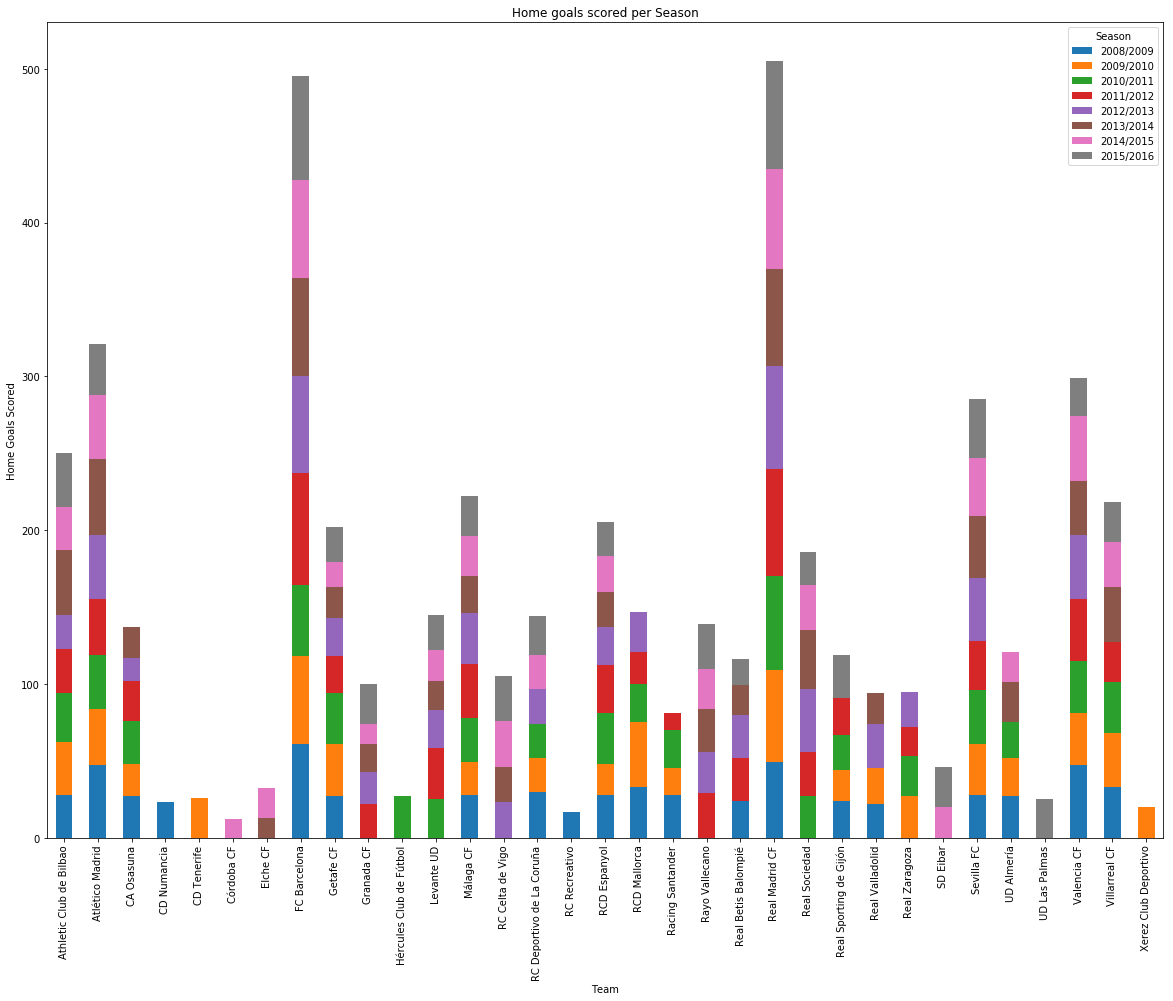

Season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
Team_Home,,,,,,,,
Athletic Club de Bilbao,28.0,34.0,32.0,29.0,22.0,42.0,28.0,35.0
Atlético Madrid,47.0,37.0,35.0,36.0,42.0,49.0,42.0,33.0
CA Osasuna,27.0,21.0,28.0,26.0,15.0,20.0,NaN,NaN
CD Numancia,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD Tenerife,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
season_team_home_goal_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_home_goal_sum, \
    'Team_Home', 'Season', 'Team_Home_Goal', 'Home goals scored per Season', 'Team', 'Home Goals Scored', True, True)
season_team_home_goal_sum.head()

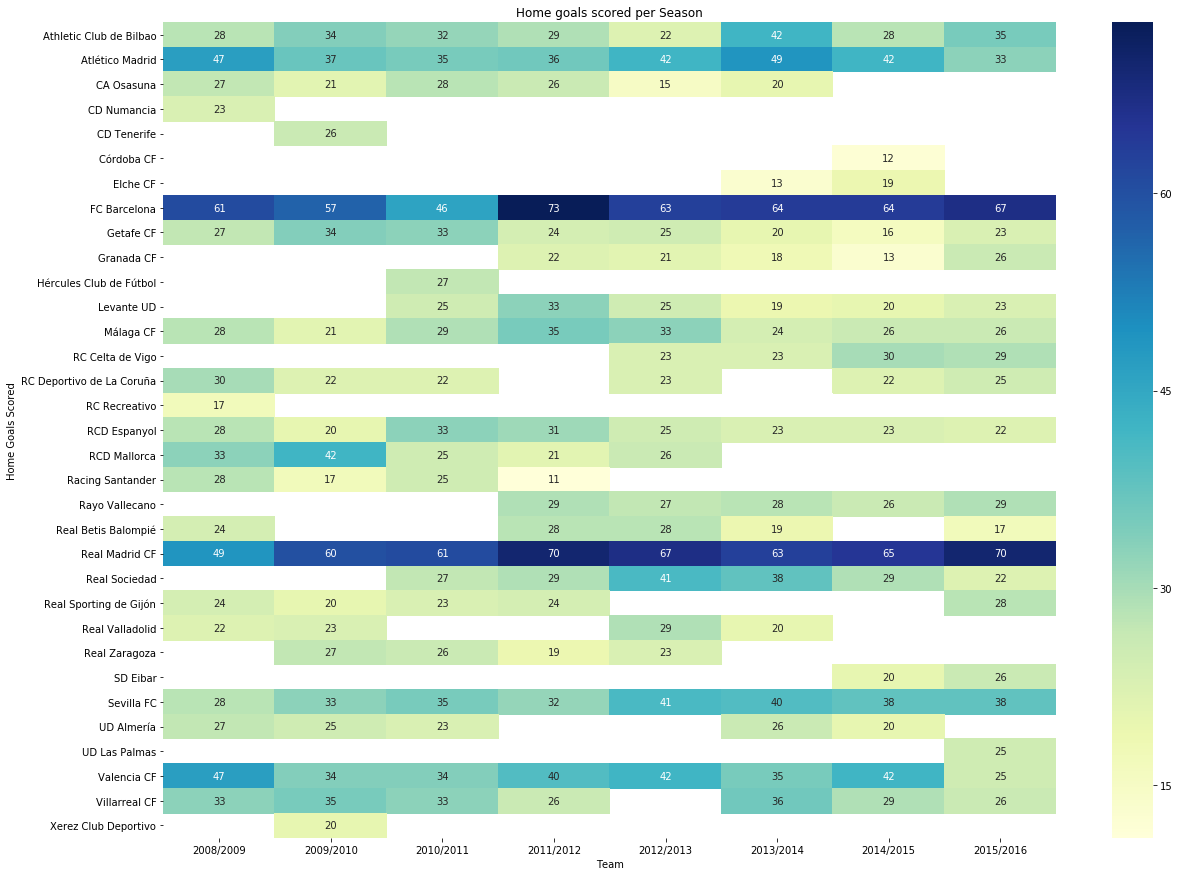

In [10]:
season_team_home_goal_sum = reset_index_pivot_plot_series('heat_map', 'YlGnBu', season_team_home_goal_sum, \
    'Team_Home', 'Season', 'Team_Home_Goal', 'Home goals scored per Season', 'Team', 'Home Goals Scored', False, False)

## Question 2: How many goals has each team scored away on each season?  
## Answer 2: Away goals scored per Season

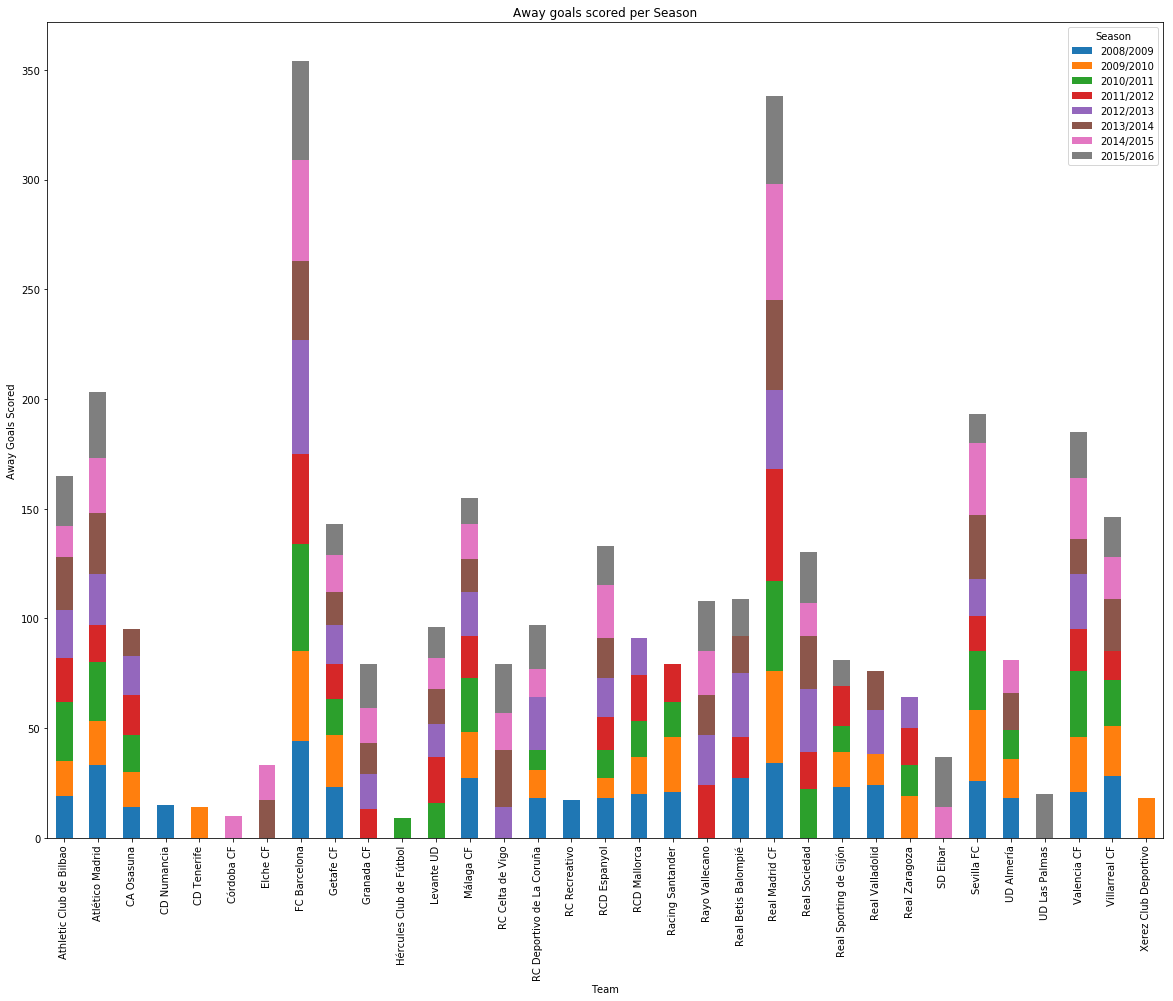

Season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
Team_Away,,,,,,,,
Athletic Club de Bilbao,19.0,16.0,27.0,20.0,22.0,24.0,14.0,23.0
Atlético Madrid,33.0,20.0,27.0,17.0,23.0,28.0,25.0,30.0
CA Osasuna,14.0,16.0,17.0,18.0,18.0,12.0,NaN,NaN
CD Numancia,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD Tenerife,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
season_team_away_goal_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_away_goal_sum, \
    'Team_Away', 'Season', 'Team_Away_Goal', 'Away goals scored per Season', 'Team', 'Away Goals Scored', True, True)
season_team_away_goal_sum.head()

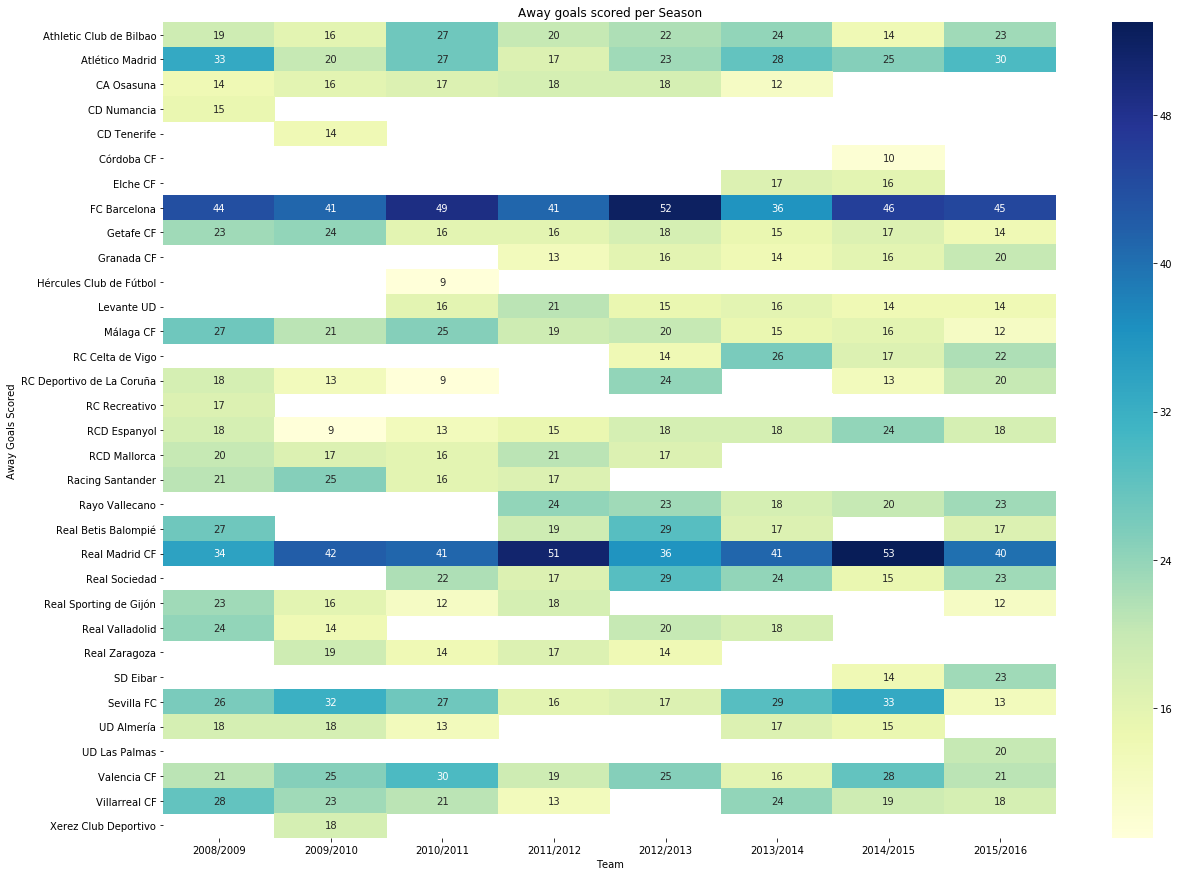

In [12]:
season_team_away_goal_sum = reset_index_pivot_plot_series('heat_map', 'YlGnBu', season_team_away_goal_sum, \
    'Team_Away', 'Season', 'Team_Away_Goal', 'Away goals scored per Season', 'Team', 'Away Goals Scored', False, False)

## Question 3: How many goals has each team scored on each season?  
## Answer 3: Total goals scored per Season

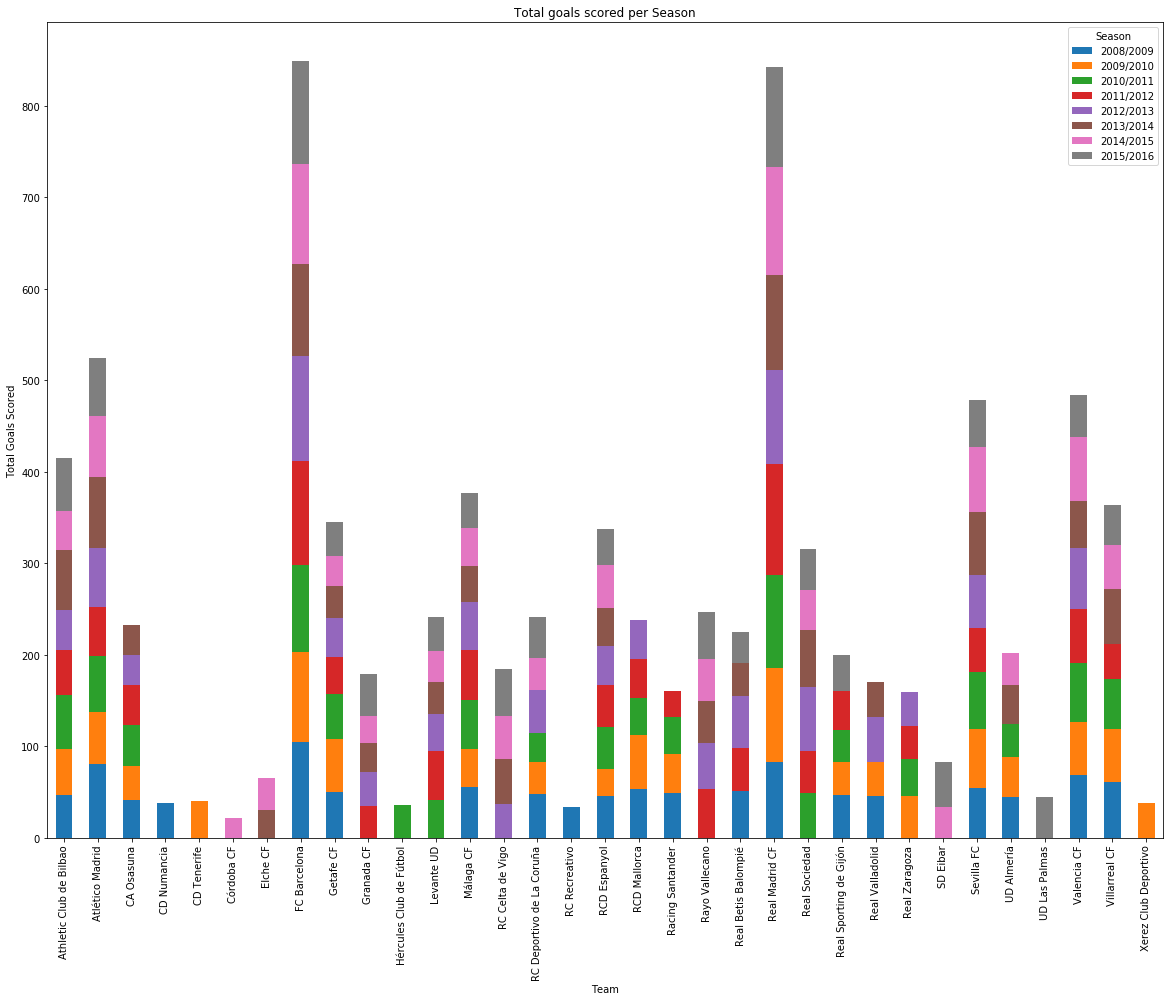

Season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
Team,,,,,,,,
Athletic Club de Bilbao,47.0,50.0,59.0,49.0,44.0,66.0,42.0,58.0
Atlético Madrid,80.0,57.0,62.0,53.0,65.0,77.0,67.0,63.0
CA Osasuna,41.0,37.0,45.0,44.0,33.0,32.0,NaN,NaN
CD Numancia,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD Tenerife,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
season_team_goal_sum = season_team_goal_sum.reset_index()
season_team_goal_sum.rename(columns={'Season': 'Season', 'Team_Home': 'Team', 0: 'Team_Goal'}, inplace=True)

season_team_goal_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_goal_sum, \
    'Team', 'Season', 'Team_Goal', 'Total goals scored per Season', 'Team', 'Total Goals Scored', False, True)
season_team_goal_sum.head()

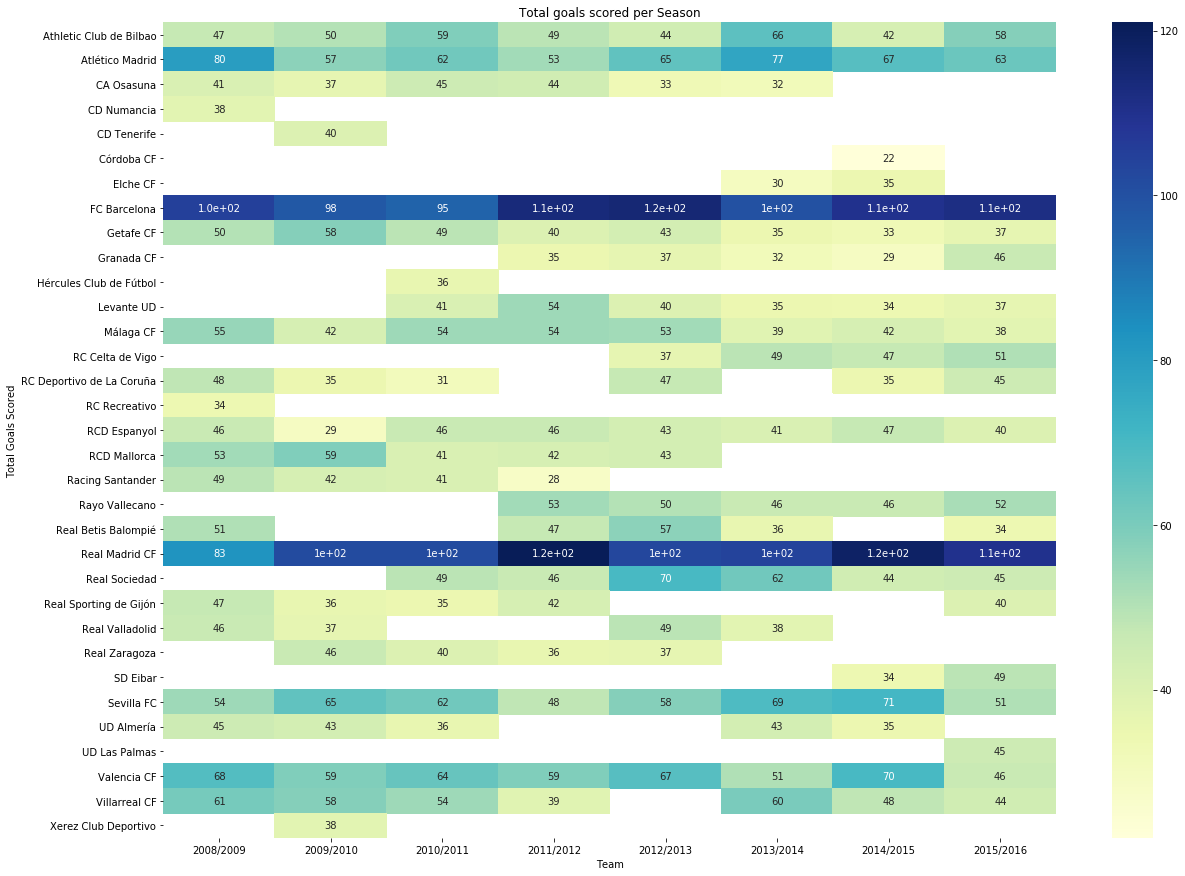

In [14]:
season_team_goal_sum = reset_index_pivot_plot_series('heat_map', 'YlGnBu', season_team_goal_sum, \
    'Team', 'Season', 'Team_Goal', 'Total goals scored per Season', 'Team', 'Total Goals Scored', False, False)

## Compute home and away goals allowed per season and add them up, store in pandas Series

In [15]:
season_team_home_allowed_sum = spain_liga_bbva_df.groupby(['Season', 'Team_Home'])['Team_Away_Goal'].sum()
season_team_away_allowed_sum = spain_liga_bbva_df.groupby(['Season', 'Team_Away'])['Team_Home_Goal'].sum()
season_team_allowed_sum = season_team_home_allowed_sum + season_team_away_allowed_sum
print type(season_team_home_allowed_sum)
print season_team_home_allowed_sum.head(30)

<class 'pandas.core.series.Series'>
Season     Team_Home                
2008/2009  Athletic Club de Bilbao      29
           Atlético Madrid              23
           CA Osasuna                   22
           CD Numancia                  22
           FC Barcelona                 14
           Getafe CF                    23
           Málaga CF                    23
           RC Deportivo de La Coruña    18
           RC Recreativo                29
           RCD Espanyol                 22
           RCD Mallorca                 24
           Racing Santander             22
           Real Betis Balompié          25
           Real Madrid CF               29
           Real Sporting de Gijón       37
           Real Valladolid              17
           Sevilla FC                   20
           UD Almería                   20
           Valencia CF                  26
           Villarreal CF                25
2009/2010  Athletic Club de Bilbao      24
           Atlético Madr

## Question 4: How many goals has each team allowed home on each season?  
## Answer 4: Home goals allowed per Season

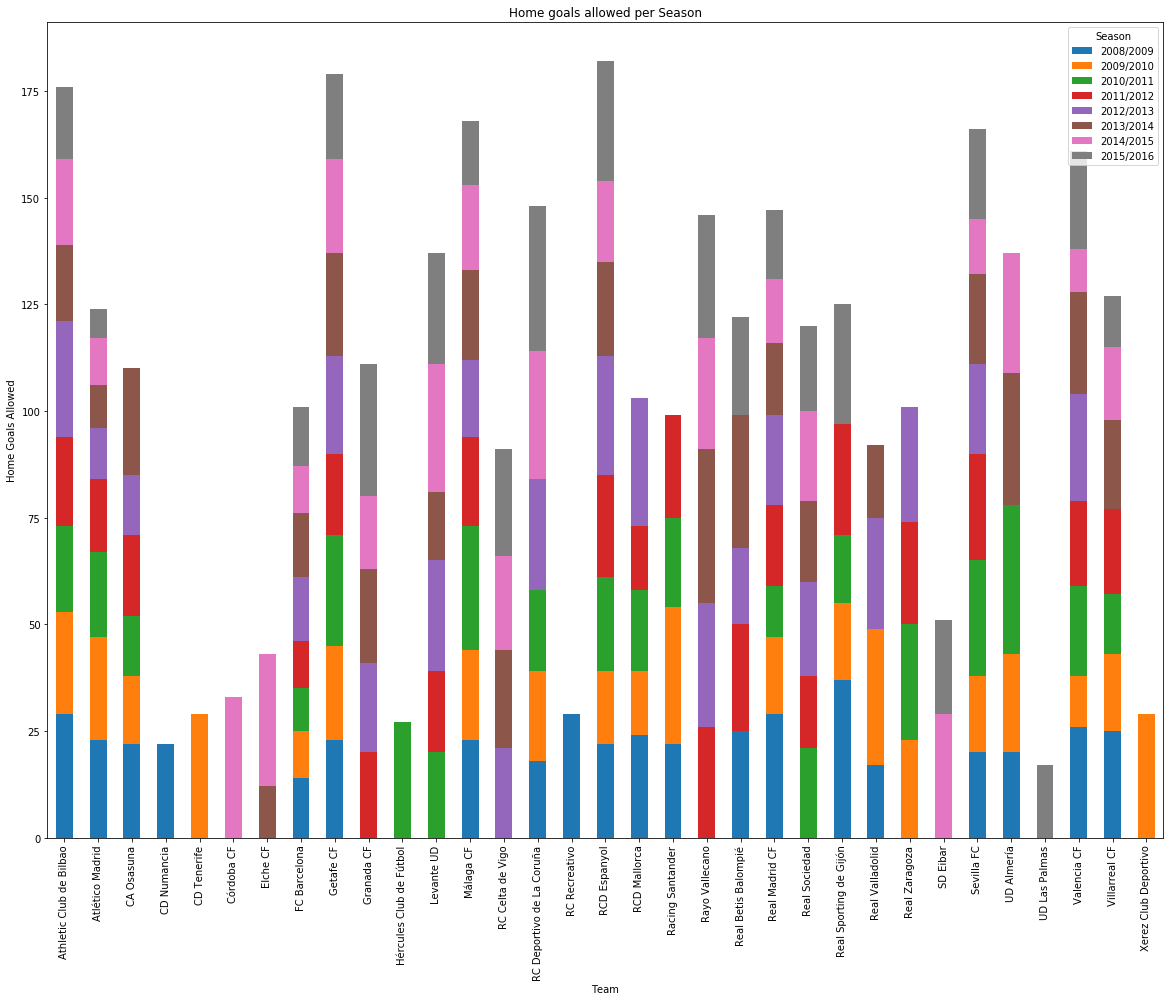

Season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
Team_Home,,,,,,,,
Athletic Club de Bilbao,29.0,24.0,20.0,21.0,27.0,18.0,20.0,17.0
Atlético Madrid,23.0,24.0,20.0,17.0,12.0,10.0,11.0,7.0
CA Osasuna,22.0,16.0,14.0,19.0,14.0,25.0,NaN,NaN
CD Numancia,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD Tenerife,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
season_team_home_allowed_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_home_allowed_sum, \
    'Team_Home', 'Season', 'Team_Away_Goal', 'Home goals allowed per Season', 'Team', 'Home Goals Allowed', True, True)
season_team_home_allowed_sum.head()

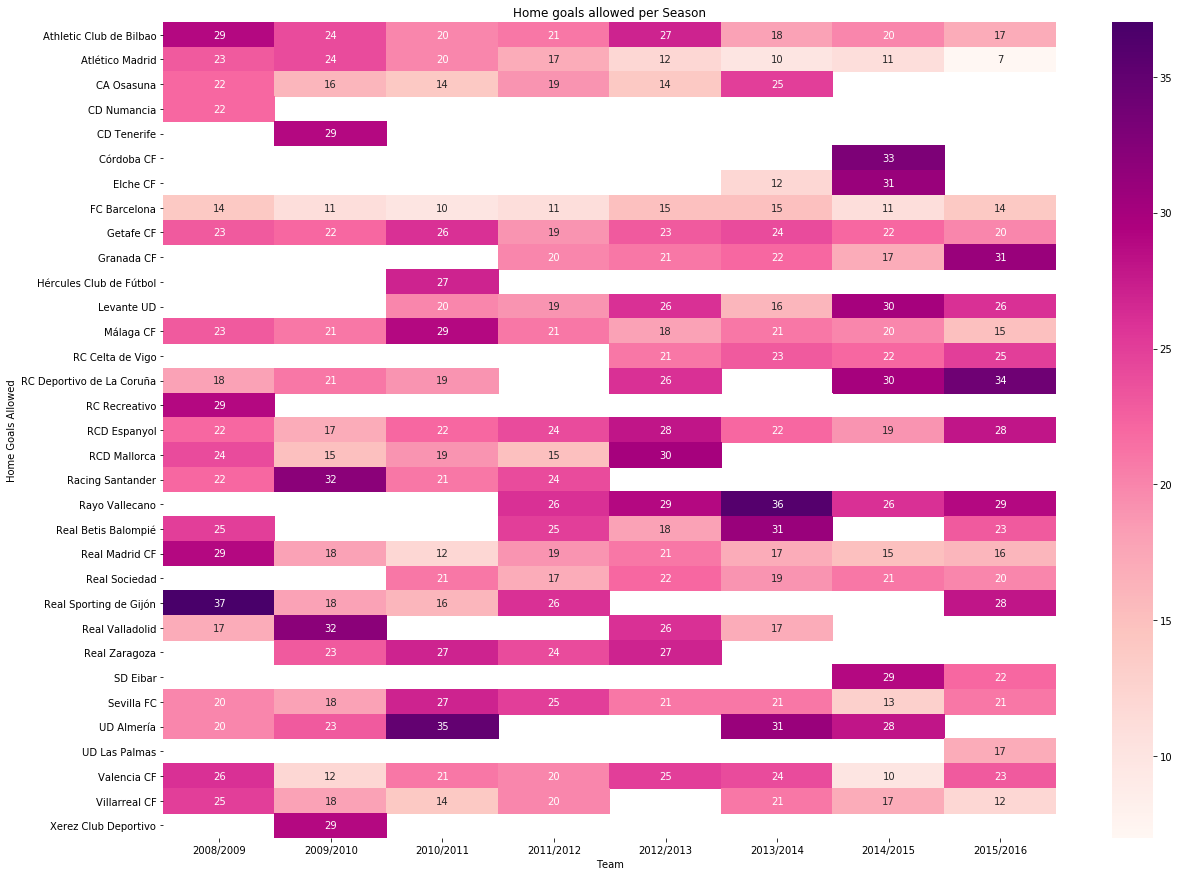

In [17]:
season_team_home_allowed_sum = reset_index_pivot_plot_series('heat_map', 'RdPu', season_team_home_allowed_sum, \
    'Team_Home', 'Season', 'Team_Away_Goal', 'Home goals allowed per Season', 'Team', 'Home Goals Allowed', False, False)

## Question 5: How many goals has each team allowed away on each season?
## Answer 5: Away goals allowed per Season

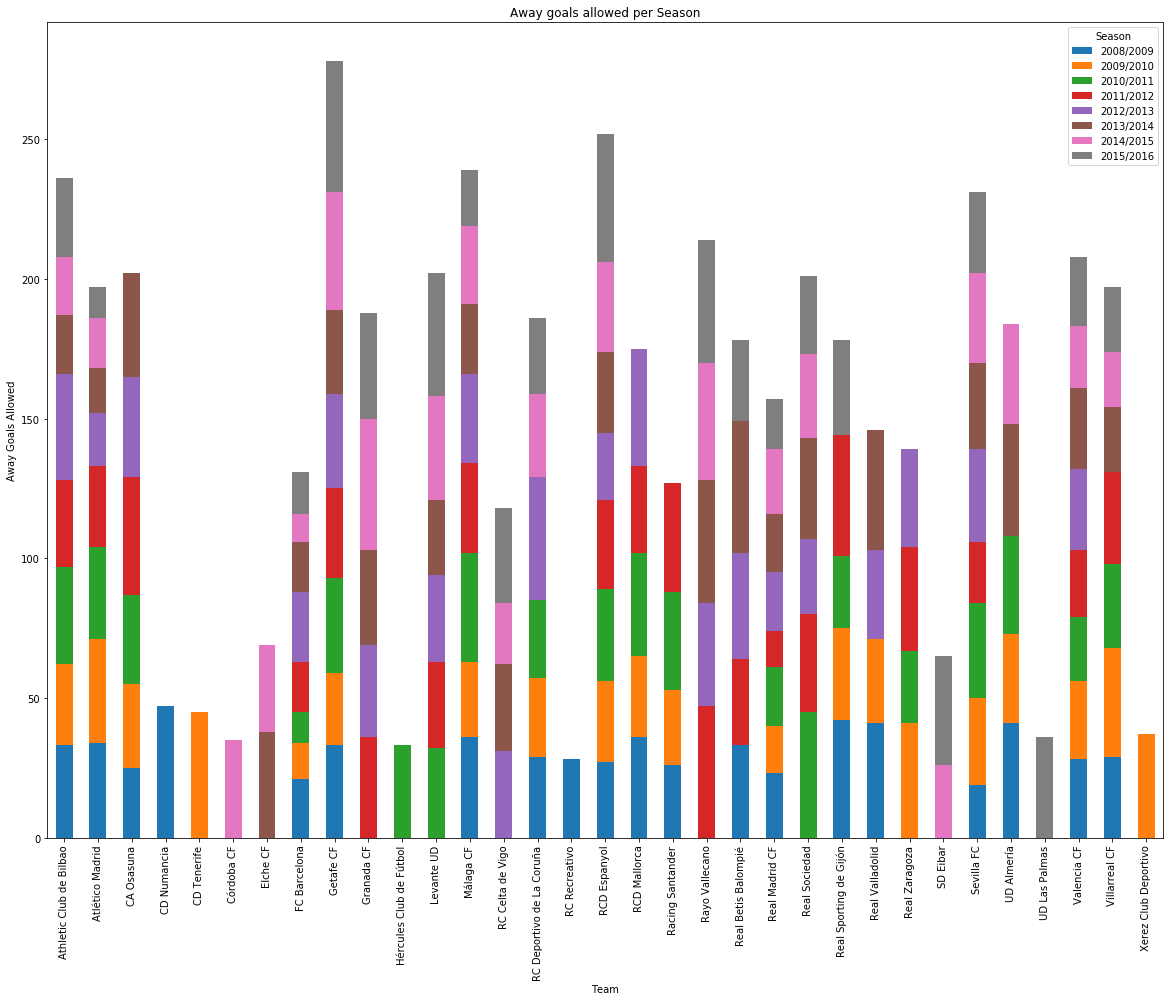

Season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
Team_Away,,,,,,,,
Athletic Club de Bilbao,33.0,29.0,35.0,31.0,38.0,21.0,21.0,28.0
Atlético Madrid,34.0,37.0,33.0,29.0,19.0,16.0,18.0,11.0
CA Osasuna,25.0,30.0,32.0,42.0,36.0,37.0,NaN,NaN
CD Numancia,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD Tenerife,NaN,45.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
season_team_away_allowed_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_away_allowed_sum, \
    'Team_Away', 'Season', 'Team_Home_Goal', 'Away goals allowed per Season', 'Team', 'Away Goals Allowed', True, True)
season_team_away_allowed_sum.head()

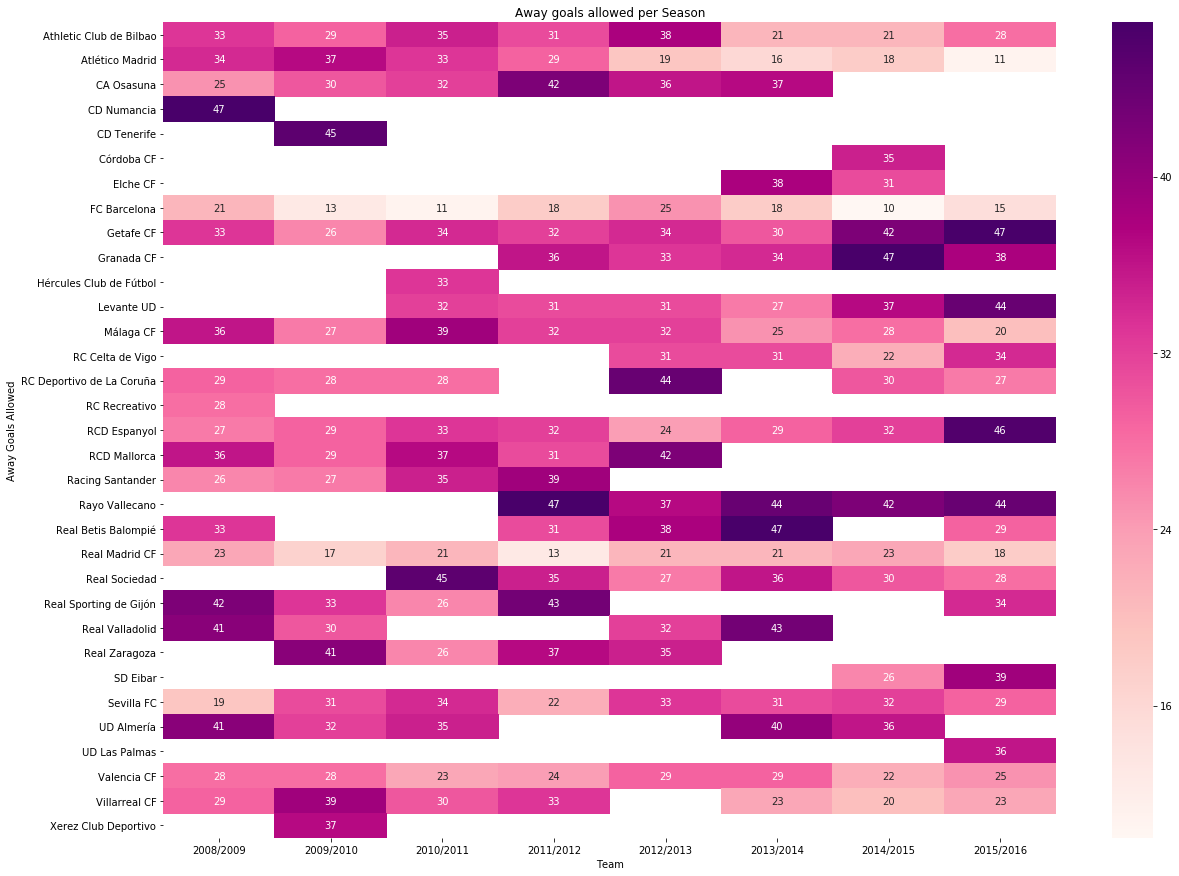

In [19]:
season_team_away_allowed_sum = reset_index_pivot_plot_series('heat_map', 'RdPu', season_team_away_allowed_sum, \
    'Team_Away', 'Season', 'Team_Home_Goal', 'Away goals allowed per Season', 'Team', 'Away Goals Allowed', False, False)

## Question 6: How many goals has each team allowed on each season?
## Answer 6: Total goals allowed per Season

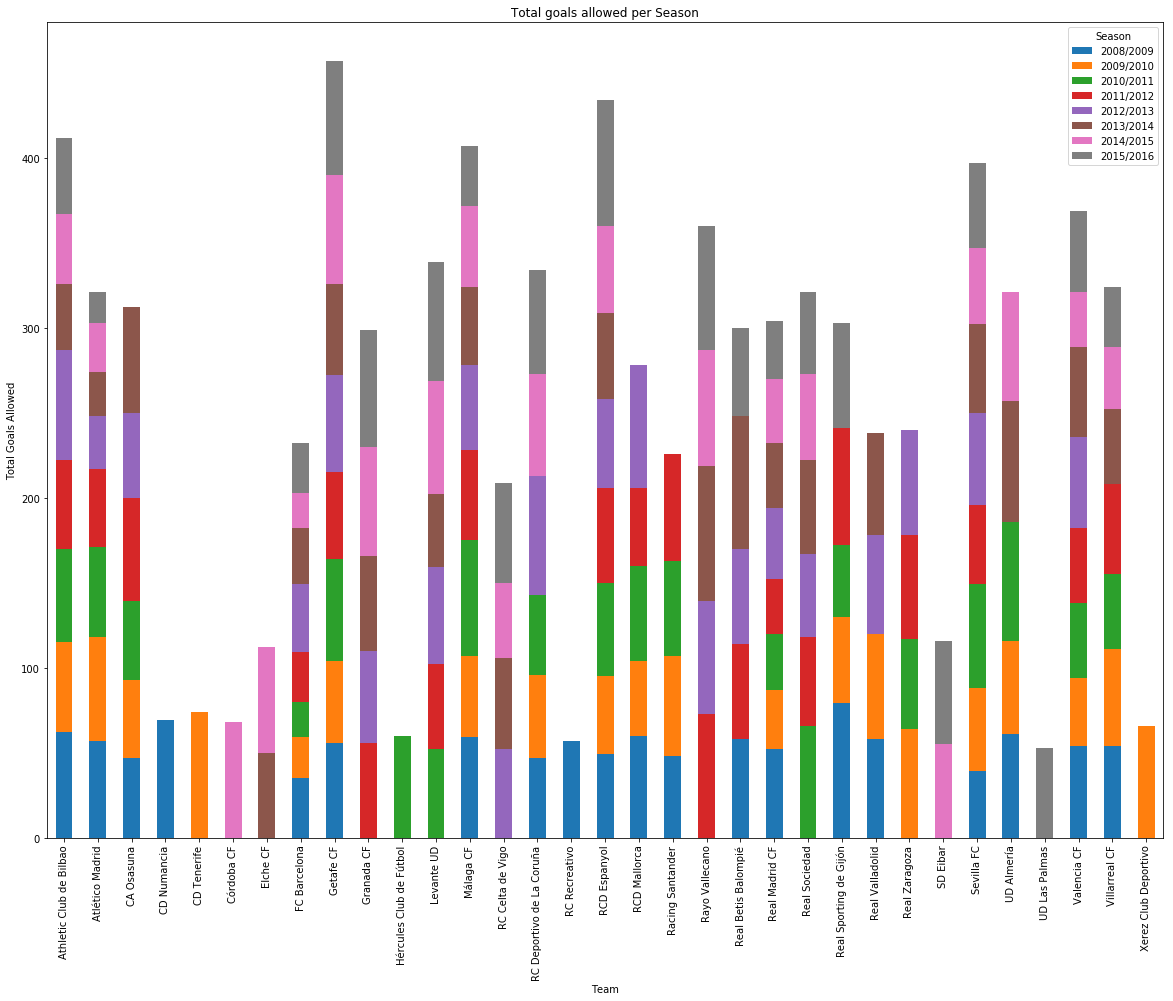

Season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
Team,,,,,,,,
Athletic Club de Bilbao,62.0,53.0,55.0,52.0,65.0,39.0,41.0,45.0
Atlético Madrid,57.0,61.0,53.0,46.0,31.0,26.0,29.0,18.0
CA Osasuna,47.0,46.0,46.0,61.0,50.0,62.0,NaN,NaN
CD Numancia,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD Tenerife,NaN,74.0,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
season_team_allowed_sum = season_team_allowed_sum.reset_index()
season_team_allowed_sum.rename(columns={'Season': 'Season', 'Team_Home': 'Team', 0: 'Team_Allowed'}, inplace=True)

season_team_allowed_sum = reset_index_pivot_plot_series('stacked_bar', '', season_team_allowed_sum, \
    'Team', 'Season', 'Team_Allowed', 'Total goals allowed per Season', 'Team', 'Total Goals Allowed', False, True)
season_team_allowed_sum.head()

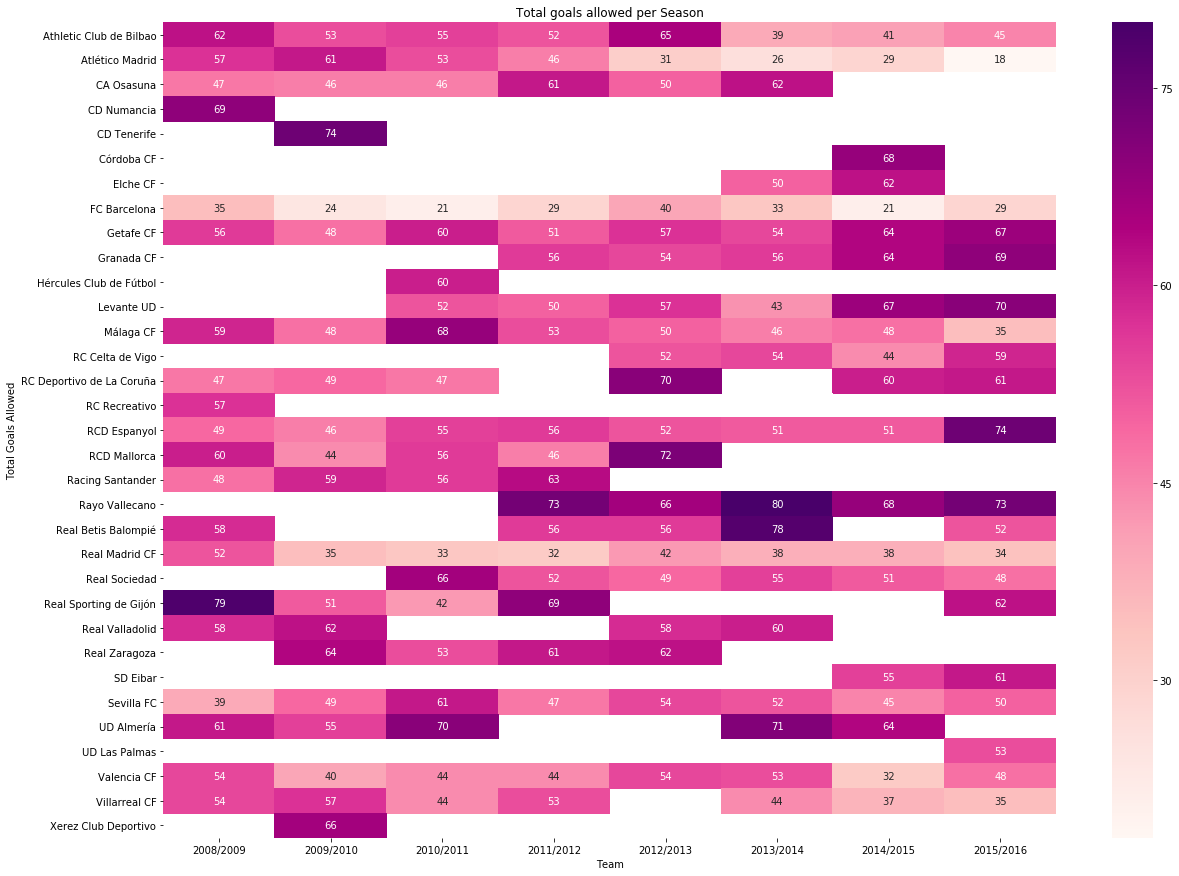

In [21]:
season_team_allowed_sum = reset_index_pivot_plot_series('heat_map', 'RdPu', season_team_allowed_sum, \
    'Team', 'Season', 'Team_Allowed', 'Total goals allowed per Season', 'Team', 'Total Goals Allowed', False, False)

## Matplotlib colormap reference  
https://matplotlib.org/examples/color/colormaps_reference.html
## Personal favorites for displaying positive impact: 'YlGnBu', 'cool'
## Personal favorites for displaying positive impact: 'RdPu', 'magma_r', 'plasma_r'

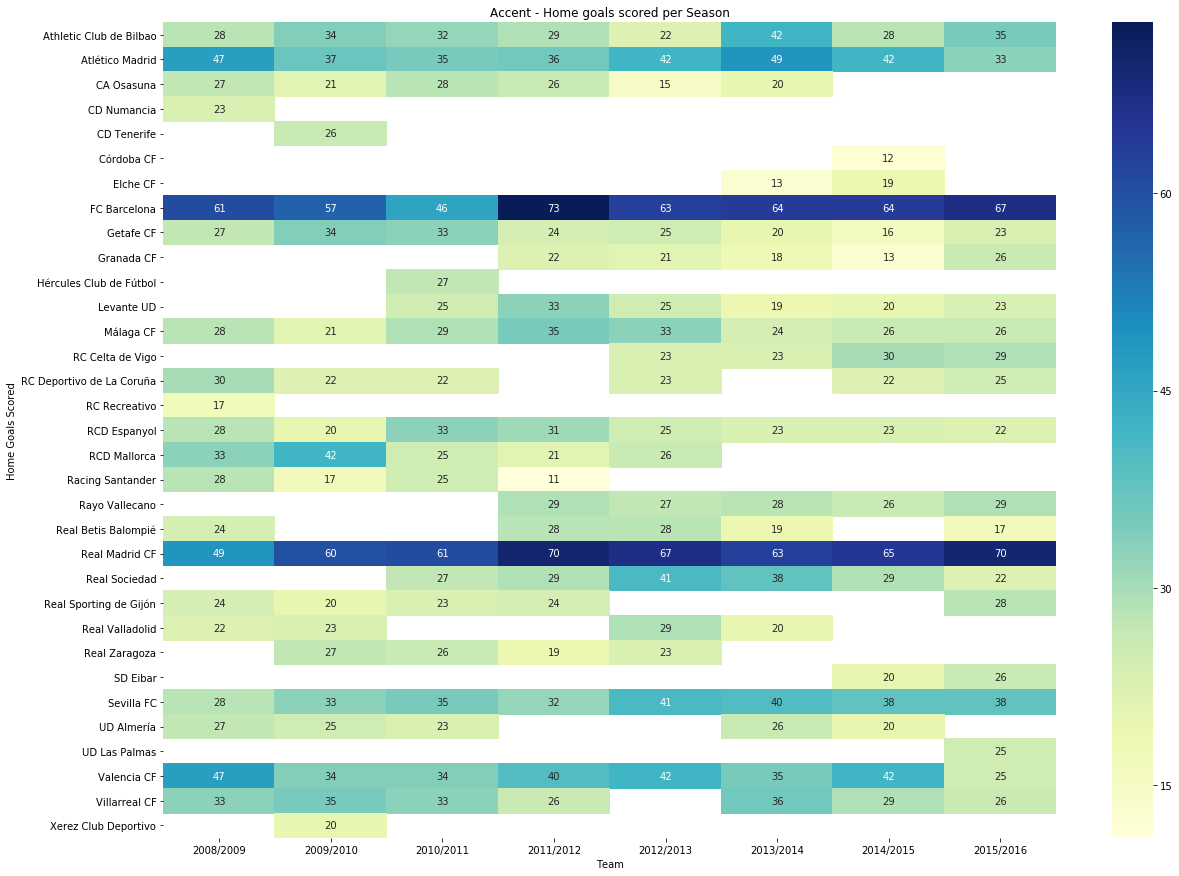

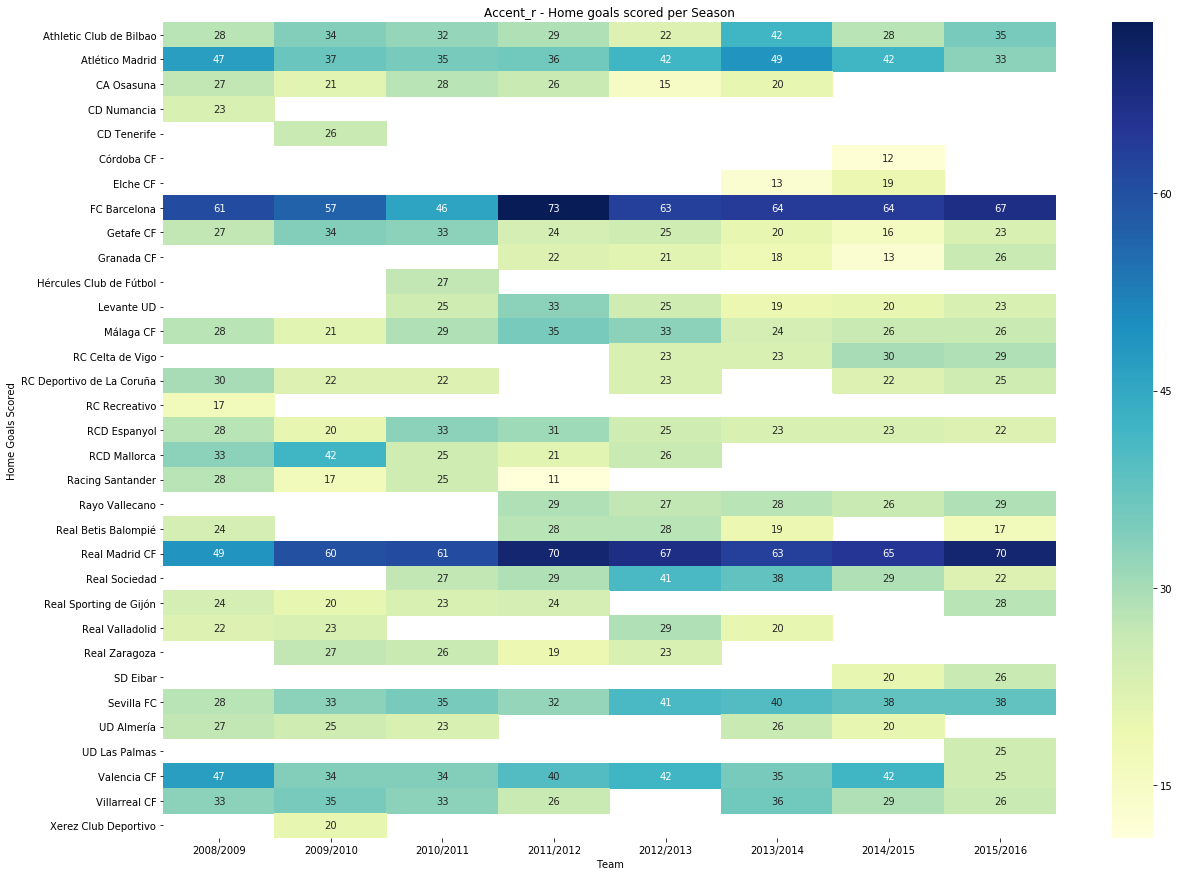

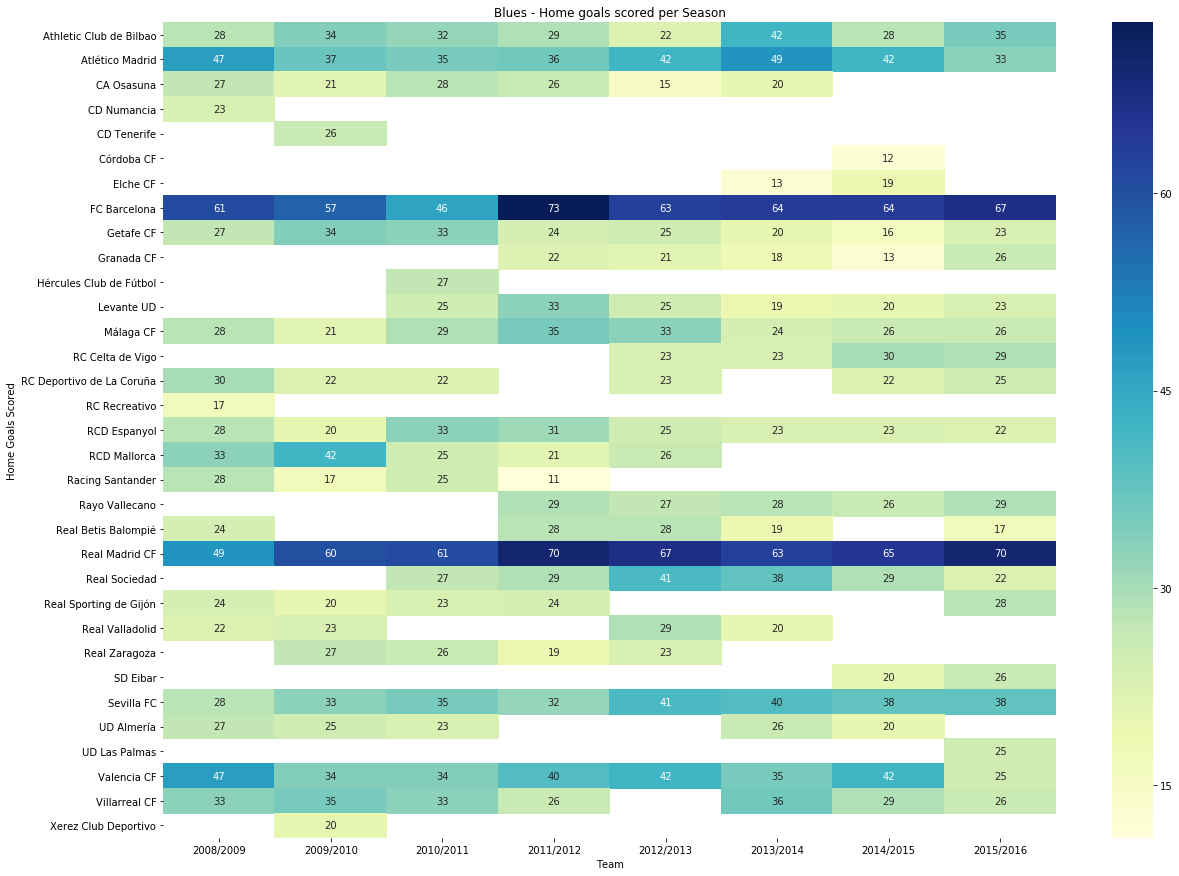

In [23]:
plot_colors = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

for plot_color in plot_colors[:3]:
    season_team_home_goal_sum = reset_index_pivot_plot_series('heat_map', 'YlGnBu', season_team_home_goal_sum, \
    'Team_Home', 'Season', 'Team_Home_Goal', plot_color + ' - Home goals scored per Season', 'Team', 'Home Goals Scored', False, False)